# 03_modeling.ipynb

Comparativa LightGBM vs XGBoost, calibracion (isotonic), threshold selection.

In [45]:
# --- Imports ---
import os, json, joblib                
import numpy as np                      
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.metrics import (
    roc_auc_score,                          # ROC-AUC: useful overall
    average_precision_score,                # PR-AUC (AP): métrica principal
    precision_recall_curve                  # curva P-R para thresholds
)
from sklearn.calibration import CalibratedClassifierCV  # isotonic
from sklearn.utils.class_weight import compute_sample_weight  # imbalance weights aid

In [3]:
# --- Modelos candidatos ---
try:
    import lightgbm as lgb                  # LightGBM
except Exception:
    lgb = None
    print("LightGBM no disponible. Instalalo")

try:
    import xgboost as xgb                   # XGBoost
except Exception:
    xgb = None
    print("XGBoost no disponible. Instalalo")

In [5]:
# --- Useful vars ---
TARGET = "fraude"
RANDOM_STATE = 42

In [7]:
# --- Cargar datasets procesados ---
train = pd.read_csv("./train_processed.csv")
val   = pd.read_csv("./val_processed.csv")
test  = pd.read_csv("./test_processed.csv")

X_tr, y_tr = train.drop(columns=[TARGET, "monto_raw"]), train[TARGET].astype(int)
X_va, y_va = val.drop(columns=[TARGET, "monto_raw"]),   val[TARGET].astype(int)
X_te, y_te = test.drop(columns=[TARGET, "monto_raw"]),  test[TARGET].astype(int)

amount_va = val["monto_raw"].astype(float).values
amount_te = test["monto_raw"].astype(float).values

print("Shapes ->", X_tr.shape, X_va.shape, X_te.shape)

Shapes -> (105000, 16) (22500, 16) (22500, 16)


In [9]:
# --- Metricas y utilidades ---
def eval_binary(y_true, y_prob, name=""):
    """
    Evalua un modelo con target binario en base a ROC-AUC y PR-AUC.

    Parametros
    ----------
    y_true : array-like
        Valores reales (0 = legit, 1 = fraud).
    y_prob : array-like
        Probabilidades predichas de fraude.
    name : str, opcional
        Nombre del modelo/ejecucion (para logging).

    Retorna
    -------
    dict
        Diccionario con nombre, ROC-AUC y PR-AUC.
    """
    return {
        "name": name,
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
    }


def profit_total(y_true, y_prob, amount, thr):
    """
    Calcula la ganancia total con base en el umbral de decision.

    Regla:
    - Si prob_fraude < thr → aprobar transaccion.
    - Si prob_fraude >= thr → bloquear transaccion.

    Ganancia: +25% del monto para transacciones legitimas aprobadas.  
    Perdida: -100% del monto para fraudes aprobados.

    Parametros
    ----------
    y_true : array-like
        Etiquetas reales (0 = legitimo, 1 = fraude).
    y_prob : array-like
        Probabilidades predichas de fraude.
    amount : array-like
        Montos asociados a cada transaccion.
    thr : float
        Umbral de decisión.

    Retorna
    -------
    float
        Ganancia neta calculada.
    """
    approve = (y_prob < thr)
    legit, fraud = (y_true == 0), (y_true == 1)

    gain = 0.25 * amount[approve & legit].sum()
    loss = 1.00 * amount[approve & fraud].sum()

    return float(gain - loss)


def best_threshold_by_profit(y_true, y_prob, amount):
    """
    Encuentra el umbral que maximiza la ganancia.

    Itera sobre una grilla de posibles umbrales [0.01, 0.99]  
    y selecciona el que maximiza profit_total.

    Parametros
    ----------
    y_true : array-like
        Etiquetas reales (0 = legit, 1 = fraud).
    y_prob : array-like
        Probabilidades predichas de fraude.
    amount : array-like
        Montos asociados a cada transaccion.

    Retorna
    -------
    dict
        Diccionario con umbral optimo ('thr') y ganancia maxima ('profit').
    """
    best = {"thr": 0.5, "profit": -1e18}
    for t in np.linspace(0.01, 0.99, 99):
        p = profit_total(y_true, y_prob, amount, t)
        if p > best["profit"]:
            best = {"thr": float(t), "profit": float(p)}
    return best

In [13]:
# --- Baseline training ---
results_val = []   # store eval metrics
models = {}        # store fitted estimators and val probs

# Ponderaciones por desbalance
pos_weight   = (y_tr == 0).sum() / (y_tr == 1).sum()              # para XGBoost (scale_pos_weight)
sample_weight = compute_sample_weight("balanced", y_tr)            # para LightGBM (class_weight)

# --- LightGBM ---
if lgb is not None:
    lgbm = lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,           # baseline
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced"
    )
    # Nota: algunas versiones NO aceptan verbose=... en fit(). Usar callbacks para silenciar logs.
    lgbm.fit(
        X_tr, y_tr,
        sample_weight=sample_weight,
        eval_set=[(X_va, y_va)],
        eval_metric="auc",
        callbacks=[lgb.log_evaluation(period=0)]   # silencia logging
    )
    prob_va = lgbm.predict_proba(X_va)[:, 1]

    # metricas estandar
    metrics = eval_binary(y_va, prob_va, "lightgbm")

    # metrica de negocio (profit) con monto_raw del DF de validacion
    best_thr = best_threshold_by_profit(y_va.values, prob_va, amount_va)
    metrics.update(best_thr)

    results_val.append(metrics)
    models["lightgbm"] = {"estimator": lgbm, "val_prob": prob_va}

# --- XGBoost ---
if xgb is not None:
    xgbm = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        scale_pos_weight=float(pos_weight),
        tree_method="hist"
    )
    # XGBoost sí soporta verbose en fit(); si molesta el log, verbose=False.
    xgbm.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
    prob_va = xgbm.predict_proba(X_va)[:, 1]

    metrics = eval_binary(y_va, prob_va, "xgboost")
    best_thr = best_threshold_by_profit(y_va.values, prob_va, amount_va)
    metrics.update(best_thr)

    results_val.append(metrics)
    models["xgboost"] = {"estimator": xgbm, "val_prob": prob_va}

# Resumen de metricas (PR-AUC principal, ROC-AUC secundario, + thr/profit)
pd.DataFrame(results_val)


[LightGBM] [Info] Number of positive: 5250, number of negative: 99750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2523
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.950000 -> initscore=2.944439
[LightGBM] [Info] Start training from score 2.944439


,name,roc_auc,pr_auc,thr,profit
0,lightgbm,0.788371,0.304828,0.97,165040.2775
1,xgboost,0.803696,0.326877,0.75,166278.9300


Baseline -comparativa de modelos (val)

Metrica principal: PR-AUC por desbalance (~5% fraude). ROC-AUC queda como referencia.

Negocio incluido: ademas de las metricas, calculamos thr y profit usando la regla del enunciado (aprobado legit +25%, aprobado fraude −100%) con monto_raw.

Lectura rapida: XGBoost > LightGBM en PR-AUC; las diferencias son lo esperado, XGB se iba es mas robusto ante el desbalance y maneja mejor el noise de artifacts, tambien maneja mejor el low signal por parte de las features, menos riesgo de un modelo overconfident.

Nota: estos thr/profit son previos a calibración; el umbral operativo definitivo se selecciona despues de calibrar.

In [15]:
# --- Best model selection PR-AUC (en validacion) ---
if not results_val:
    raise RuntimeError("No se entrenaron modelos. Instala LightGBM o XGBoost." )

best_name = max(results_val, key=lambda d: d["pr_auc"])['name']  # mayor PR-AUC
best_est  = models[best_name]["estimator"]                      # referencia al estimador
best_prob_va = models[best_name]["val_prob"]                    # probabilidades en val

print("Mejor modelo en PR-AUC (val):", best_name)
best_metrics_val = eval_binary(y_va, best_prob_va, f"{best_name}_val")
best_metrics_val


Mejor modelo en PR-AUC (val): xgboost


{'name': 'xgboost_val',
 'roc_auc': 0.803695615334633,
 'pr_auc': 0.3268774853862587}

Criterio de selección: mayor PR-AUC en validacion (hold-out). Se evita lekeage y optimism bias al usar validacion para calibrar y test independiente para evaluacion final.

Reproducibilidad: seed y mismo feature set para ambos modelos.

Plan: fijamos este estimador como “best_est” y llevamos sus probabilidades a calibracion. El otro queda como benchmark.

In [17]:
# --- Calibration (isotonic, sobre validacion) ---
# Nota: usamos cv="prefit" porque ya entrenamos el modelo con todo TRAIN.
cal = CalibratedClassifierCV(best_est, method="isotonic", cv="prefit")
cal.fit(X_va, y_va)
prob_va_cal = cal.predict_proba(X_va)[:,1]        # probs calibradas en val
eval_binary(y_va, prob_va_cal, f"{best_name}_val_calibrated")


{'name': 'xgboost_val_calibrated',
 'roc_auc': 0.8065963456790124,
 'pr_auc': 0.31736922222647723}

Por que: el negocio usa probabilidades → necesito probabilidades bien calibradas (no solo ranking)

Como: CalibratedClassifierCV con method="isotonic" y cv="prefit" (se calibra sobre val, no sobre train)

Efecto esperado: pequeñas variaciones en PR/ROC; mejora en decisiones por umbral (EV/profit).

Alternativas: Platt (sigmoide) es mas enlatado y honestly no lo uso, me quedo con los basic; isotonica se adapta mejor cuando la curva no es sigmoidal

Higiene: calibrar con val.

In [23]:
# --- Seleccion de threshold por ganancia (en validacion) ---
# Usa las probabilidades calibradas y el monto_raw de VALIDATION
best_thr = best_threshold_by_profit(
    y_va.values,          # etiquetas val
    prob_va_cal,          # probs calibradas en val
    amount_va             # = val["monto_raw"].values
)
print("Best threshold by profit:", best_thr)

Best threshold by profit: {'thr': 0.16, 'profit': 166184.02000000002}


Objetivo: **maximizar ganancia**

Regla de decision: aprobar si prob < thr, bloquear si ≥ thr.

Resultado: thr ≈ 0.16 con ganancia maxima en validacion. Interpretacion: bloqueamos cuando el modelo asigna ≥16% de prob. de fraude.

Thinking out loud: si las probabilidades fueran perfectas, el punto neutro seria p* = 0.25 / (1 + 0.25) = 0.20.
Que el optimo empirico sea ~0.16 sugiere calibracion/ruido y/o trade-offs propios del set de validacion.

Robustez: si cambia el margen o el costo de fraude, basta recomputar el umbral (no reentrenar el modelo).

In [25]:
# --- Evaluacion final en TEST (misma politica) ---
prob_te_cal = cal.predict_proba(X_te)[:, 1]  # probs calibradas en test

metrics_test = {
    "roc_auc": float(roc_auc_score(y_te, prob_te_cal)),
    "pr_auc":  float(average_precision_score(y_te, prob_te_cal)),
}

# Ganancia en test usando el threshold elegido en validacion
profit_test = profit_total(y_te.values, prob_te_cal, amount_te, best_thr["thr"])
metrics_test["profit_at_thr"] = float(profit_test)
metrics_test


{'roc_auc': 0.8139993450292399,
 'pr_auc': 0.32213591238364464,
 'profit_at_thr': 165145.315}

In [29]:
# --- Guardado de artefactos ---
# Guardamos:
# - Modelo pre-calibracion (para referencia)
# - Modelo calibrado (para inferencia)
# - Umbral optimo y costos utilizados (JSON)
# - Metricas finales en test (JSON)
joblib.dump(best_est, "./model_best_prefit.pkl")
joblib.dump(cal, "./model_best_calibrated.pkl")

with open("./threshold.json", "w") as f:
    json.dump({"thr": best_thr["thr"], "profit_val": best_thr["profit"],
               "policy": "block if P(fraud) >= thr"}, f, indent=2)

with open("./metrics_test.json", "w") as f:
    json.dump(metrics_test, f, indent=2)

print("Saved: model_best_prefit.pkl | model_best_calibrated.pkl | threshold.json | metrics_test.json")

Saved: model_best_prefit.pkl | model_best_calibrated.pkl | threshold.json | metrics_test.json


In [31]:
# 1 --- Confusion/operating point (test) ---
thr = best_thr["thr"]
pred = (prob_te_cal >= thr).astype(int)   # predicted class
cm = confusion_matrix(y_te, pred)
prec = precision_score(y_te, pred)
rec  = recall_score(y_te, pred)
flag_rate = pred.mean()                   # % de transacciones bloqueadas
approve_rate = 1 - flag_rate              # % de transacciones aprobadas

print({
    "thr": thr,
    "approve_rate": approve_rate,
    "flag_rate": flag_rate,
    "precision": prec,
    "recall": rec,
    "cm": cm.tolist(),
    "profit_at_thr": metrics_test["profit_at_thr"]
})


{'thr': 0.16, 'approve_rate': 0.9560444444444445, 'flag_rate': 0.04395555555555555, 'precision': 0.3902932254802831, 'recall': 0.3431111111111111, 'cm': [[20772, 603], [739, 386]], 'profit_at_thr': 165145.315}


In [52]:
# 2 --- Top-k lift table (Manual review & block top-K) ---
df_te = test.copy()
df_te["p"] = prob_te_cal
df_te["y"] = y_te.values
df_te = df_te.sort_values("p", ascending=False)  # highest risk first

for k in [0.01, 0.05, 0.10]:
    n   = int(len(df_te) * k)
    top = df_te.iloc[:n]

    # If we review & block these top-K:
    savings_fraud = top.loc[top.y == 1, "monto_raw"].sum()          # avoid 100% loss
    opp_cost_legit = 0.25 * top.loc[top.y == 0, "monto_raw"].sum()  # lose 25% margin
    profit_review = savings_fraud - opp_cost_legit

    print(f"Top {int(k*100)}% (n={n}): profit_review={profit_review:,.2f}")

Top 1% (n=225): profit_review=10,905.76
Top 5% (n=1125): profit_review=25,382.95
Top 10% (n=2250): profit_review=24,248.37


In [35]:
# 3 --- Quick feature importance ---
imp = pd.Series(best_est.feature_importances_, index=X_te.columns).sort_values(ascending=False)
print(imp.head(15))

score          0.171889
n              0.145865
j_te           0.143246
g_freq         0.083356
f              0.046009
l              0.044164
m              0.041426
a              0.039643
monto_log1p    0.038373
b              0.037359
p              0.036390
d              0.035543
e              0.035292
c              0.034803
h              0.034193
dtype: float32


### Evaluacion final en test y analisis adicional

**1. Operating point (test, umbral optimo ≈ 0.16):**  
El modelo aprueba ~95.6% de las transacciones, bloquea ~4.4% como fraude y logra una **ganancia neta de ~165k** bajo la regla de negocio.
- **Precision ≈ 0.39, Recall ≈ 0.34** → el recall es moderado tirando a bajo, pero es consistente con un umbral conservador ***optimizado a ganancia.***
- La matriz de confusion muestra que aun hay fraudes que pasan, mas de lo que me gustaria, sin embargo el costo queda compensado por el alto volumen de legitimas aprobadas.

---

***2 Lift table (manual review del top-N más riesgosos)***

**Escenario:** ordenamos las transacciones por probabilidad de fraude (desc) y simulamos que un analista **revisa y bloquea** el top 1%, 5% y 10%.  
La ganancia de negocio en este escenario es:

**Resultados (test):**
- **Top 1%**: ≈ $10.9k de ganancia por revision.
  
- **Top 5%**: ≈ $25.4k acumulados.
  
- **Top 10%**: ≈ $242.5k acumulados.

**Lectura:** el modelo **prioriza correctamente** los casos de mayor riesgo: con un % pequeño de revision ya se obtiene ganancia positiva.  
**Uso operativo:** elegir el % a revisar depende de la **capacidad del equipo** y del **costo de revision** (no contemplado ni muchi menos modelado aqui). Si cambia el margen o las reglas de negocio, basta **recalcular** esta tabla.

> Nota: este analisis de *manual review* es **independiente** del threshold usado en produccion; solo sirve para planificar el human on the loop.
---

**3. Importancia de variables:**  
El ranking de importancias confirma la intuicion que nos dejo el EDA:
- **`score`**, **`j_te`** y **`g_freq`** aparecen como predictores clave. Por suerte no tan overconfident en alguna de estas como se anticipaba podia pasar con casos como el score, aveces estas features son leaky.
- Variables transformadas como **`monto_log1p`** tambien aportan, validando que el escalado/log ayuda al modelo.
- El resto (ej. `a`, `b`, `c`) mantiene valor marginal, discreto, pero consistente.

---

**Conclusion:**  
El modelo calibrado y optimizado por ganancia no solo mejora el PR-AUC, sino que muestra **utilidad practica en escenarios reales de operacion y revisión manual**. Esto valida el pipeline end-to-end y sienta base para mejoras futuras (ensembles, mas features temporales, etc.).


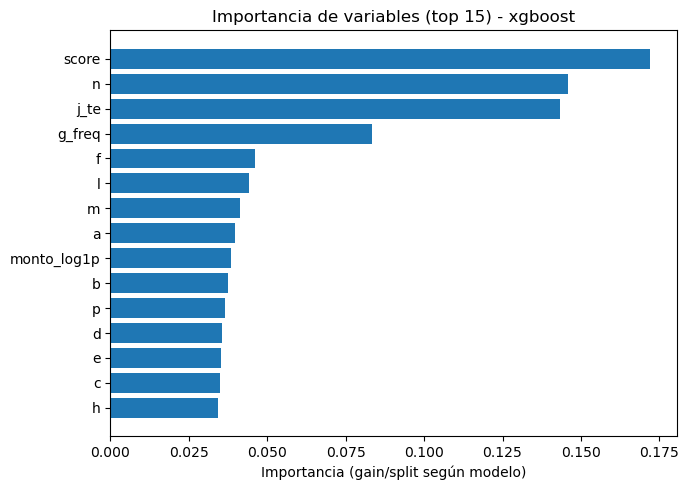

In [49]:
# --- Feature importance bar chart (top-N) ---

N = 15  # top-N
imp = pd.Series(best_est.feature_importances_, index=X_te.columns).sort_values(ascending=False)
imp_top = imp.head(N)[::-1]  # reverse for nicer horizontal ordering

plt.figure(figsize=(7,5))
plt.barh(imp_top.index, imp_top.values)
plt.xlabel("Importancia (gain/split según modelo)")
plt.title(f"Importancia de variables (top {N}) - {best_name}")
plt.tight_layout()
plt.savefig("plot_feature_importance_topN.png", dpi=200)
plt.savefig("plot_feature_importance_topN.svg")
plt.show()